In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.7 , 1.75 , 1.8/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

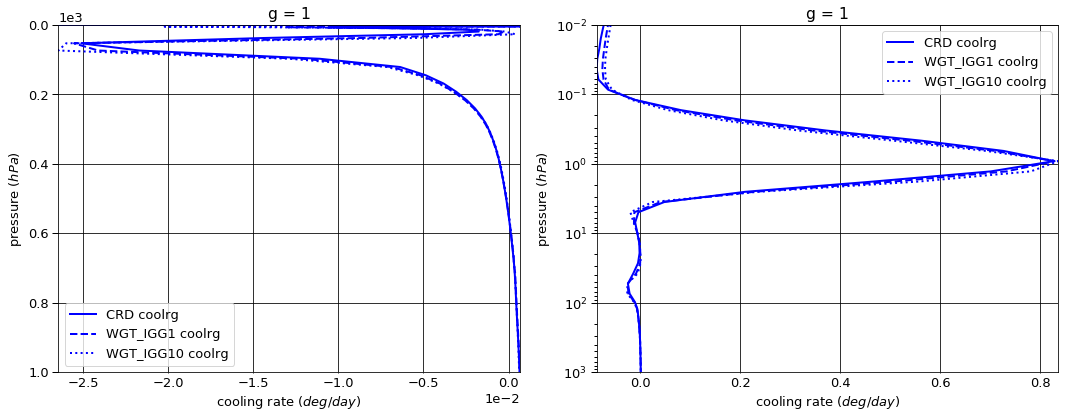

# Figure: cooling rate g-group 2

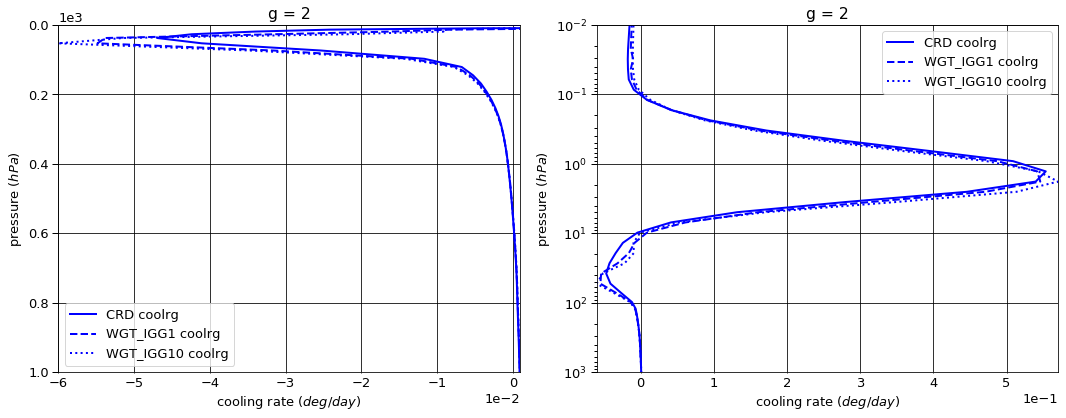

# Figure: cooling rate g-group 3

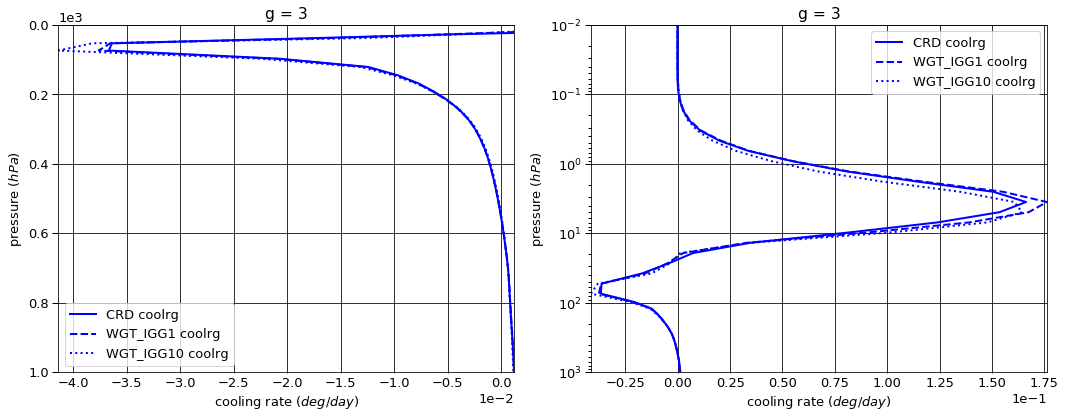

# Figure: cooling rate g-group 4

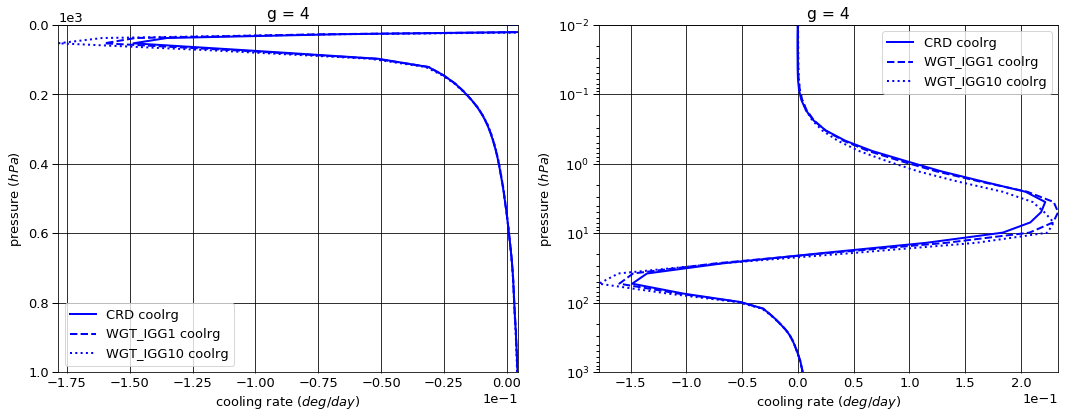

# Figure: cooling rate g-group 5

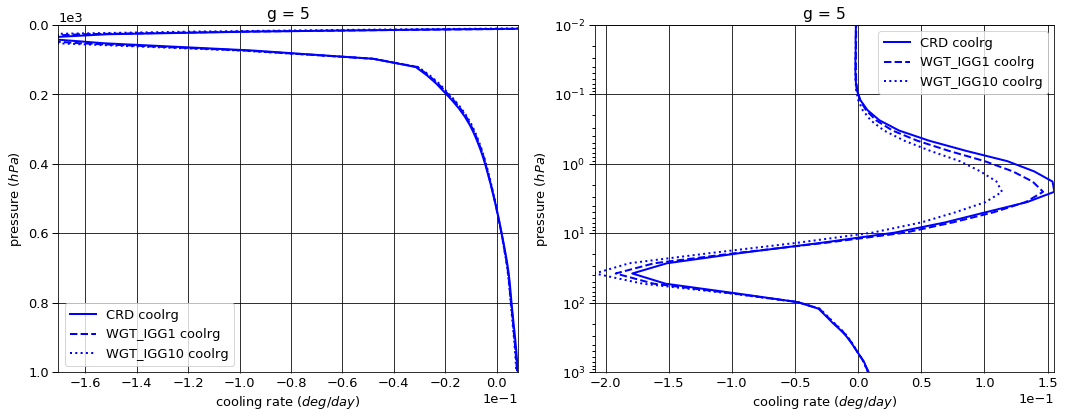

# Figure: cooling rate g-group 6

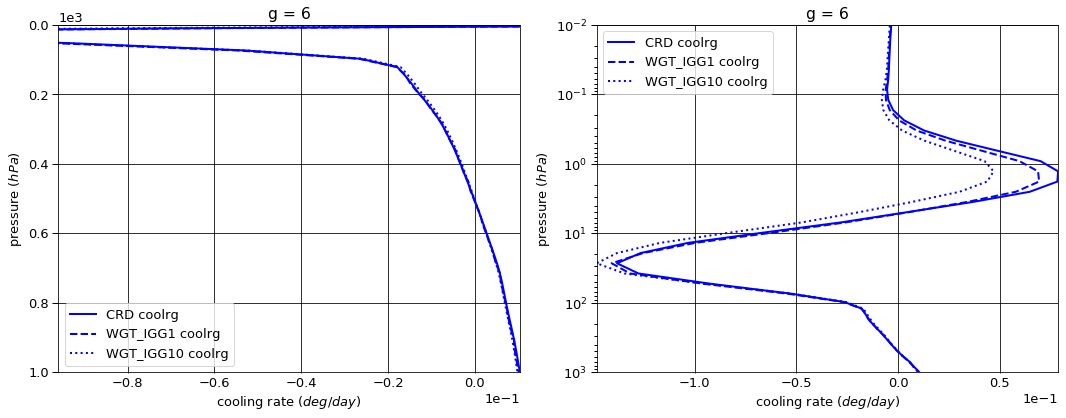

# Figure: cooling rate g-group 7

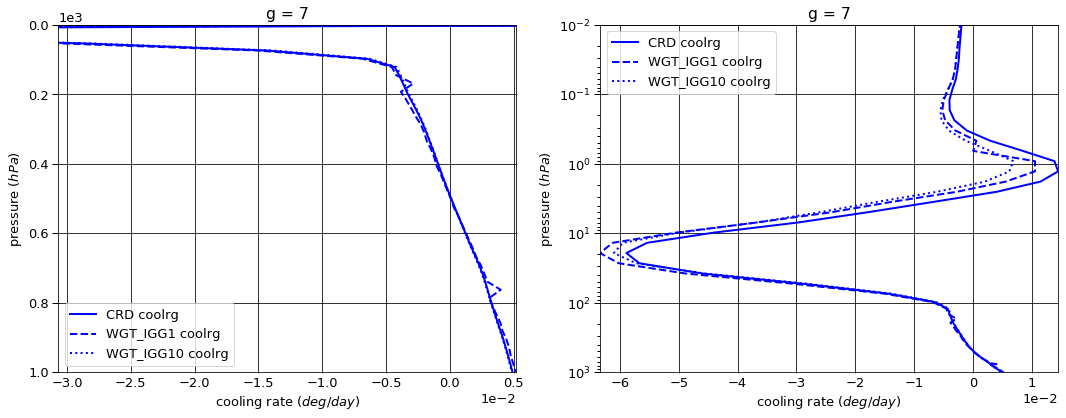

# Figure: cooling rate g-group total

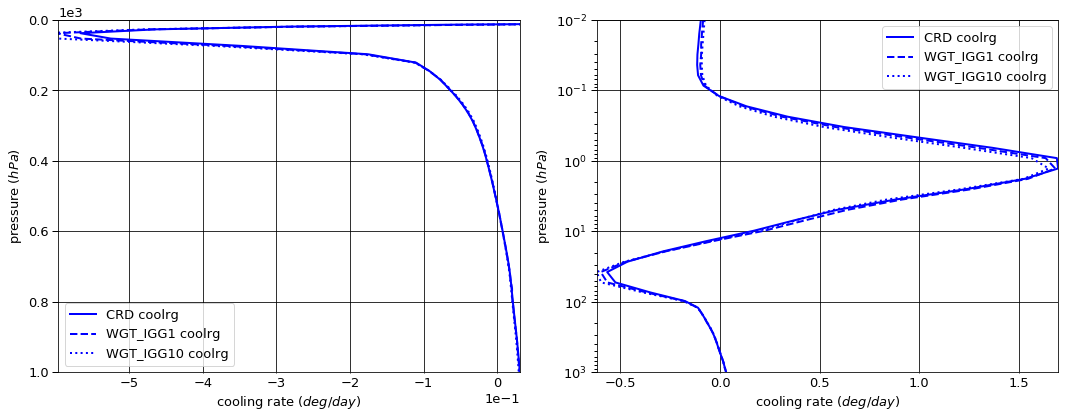

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.150335  0.000000  -0.150335
  1013.0   76     -0.325774  0.093349  -0.232425
2 0.0      1      -0.226023  0.000000  -0.226023
  1013.0   76     -0.562489  0.148174  -0.414315
3 0.0      1      -0.164987  0.000000  -0.164987
  1013.0   76     -0.564247  0.175458  -0.388790
4 0.0      1      -0.634499  0.000000  -0.634499
  1013.0   76     -2.278942  0.628577  -1.650364
5 0.0      1      -2.403533  0.000000  -2.403533
  1013.0   76     -4.873990  1.070991  -3.802999
6 0.0      1      -6.157922  0.000000  -6.157922
  1013.0   76     -8.126444  1.058015  -7.068429
7 0.0      1     -17.303207  0.000000 -17.303207
  1013.0   76    -17.996756  0.416257 -17.580499


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.152586  0.000000  -0.152586
  1013.0   76     -0.325774  0.093562  -0.232212
2 0.0      1      -0.222178  0.000000  -0.222178
  1013.0   76     -0.562489  0.142625  -0.419865
3 0.0      1      -0.168665  0.000000  -0.168665
  1013.0   76     -0.564247  0.175832  -0.388415
4 0.0      1      -0.604264  0.000000  -0.604264
  1013.0   76     -2.278942  0.628820  -1.650122
5 0.0      1      -2.382093  0.000000  -2.382093
  1013.0   76     -4.873990  1.042158  -3.831832
6 0.0      1      -6.143466  0.000000  -6.143466
  1013.0   76     -8.126444  1.042483  -7.083961
7 0.0      1     -17.254959  0.000000 -17.254959
  1013.0   76    -17.996756  0.437509 -17.559246


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.154965  0.000000  -0.154965
  1013.0   76     -0.325774  0.088160  -0.237614
2 0.0      1      -0.226400  0.000000  -0.226400
  1013.0   76     -0.562489  0.138194  -0.424296
3 0.0      1      -0.166560  0.000000  -0.166560
  1013.0   76     -0.564247  0.163773  -0.400474
4 0.0      1      -0.558930  0.000000  -0.558930
  1013.0   76     -2.278942  0.606987  -1.671954
5 0.0      1      -2.271161  0.000000  -2.271161
  1013.0   76     -4.873990  1.028246  -3.845744
6 0.0      1      -6.138327  0.000000  -6.138327
  1013.0   76     -8.126444  1.013650  -7.112794
7 0.0      1     -17.302067  0.000000 -17.302067
  1013.0   76    -17.996756  0.407309 -17.589447


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -2.250530e-03  0.000000 -0.002251
  1013.0   76     5.551115e-17  0.000213  0.000213
2 0.0      1      3.845040e-03  0.000000  0.003845
  1013.0   76     0.000000e+00 -0.005549 -0.005549
3 0.0      1     -3.677260e-03  0.000000 -0.003677
  1013.0   76     0.000000e+00  0.000374  0.000374
4 0.0      1      3.023557e-02  0.000000  0.030236
  1013.0   76     0.000000e+00  0.000242  0.000242
5 0.0      1      2.143950e-02  0.000000  0.021440
  1013.0   76    -8.881784e-16 -0.028833 -0.028833
6 0.0      1      1.445580e-02  0.000000  0.014456
  1013.0   76     0.000000e+00 -0.015532 -0.015532
7 0.0      1      4.824800e-02  0.000000  0.048248
  1013.0   76     0.000000e+00  0.021252  0.021253


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -4.630130e-03  0.000000 -0.004630
  1013.0   76     5.551115e-17 -0.005189 -0.005189
2 0.0      1     -3.771500e-04  0.000000 -0.000377
  1013.0   76     0.000000e+00 -0.009981 -0.009981
3 0.0      1     -1.572860e-03  0.000000 -0.001573
  1013.0   76     0.000000e+00 -0.011684 -0.011684
4 0.0      1      7.556932e-02  0.000000  0.075569
  1013.0   76     0.000000e+00 -0.021590 -0.021590
5 0.0      1      1.323719e-01  0.000000  0.132372
  1013.0   76    -8.881784e-16 -0.042745 -0.042744
6 0.0      1      1.959530e-02  0.000000  0.019595
  1013.0   76     0.000000e+00 -0.044365 -0.044365
7 0.0      1      1.140000e-03  0.000000  0.001140
  1013.0   76     0.000000e+00 -0.008949 -0.008948

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.028451
  1001.112500 75     0.000644
2 0.000312    1     -0.005778
  1001.112500 75     0.000895
3 0.000312    1     -0.000062
  1001.112500 75     0.001226
4 0.000312    1     -0.000188
  1001.112500 75     0.004274
5 0.000312    1     -0.000519
  1001.112500 75     0.008325
6 0.000312    1     -0.001132
  1001.112500 75     0.010414
7 0.000312    1     -0.000602
  1001.112500 75     0.004924


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.024941
  1001.112500 75     0.000658
2 0.000312    1     -0.004712
  1001.112500 75     0.000925
3 0.000312    1     -0.000043
  1001.112500 75     0.001239
4 0.000312    1     -0.000064
  1001.112500 75     0.004281
5 0.000312    1     -0.000581
  1001.112500 75     0.008022
6 0.000312    1     -0.001192
  1001.112500 75     0.010152
7 0.000312    1     -0.000700
  1001.112500 75     0.005220


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.022388
  1001.112500 75     0.000623
2 0.000312    1     -0.003835
  1001.112500 75     0.000918
3 0.000312    1     -0.000022
  1001.112500 75     0.001155
4 0.000312    1     -0.000011
  1001.112500 75     0.004092
5 0.000312    1     -0.000614
  1001.112500 75     0.007712
6 0.000312    1     -0.001296
  1001.112500 75     0.009860
7 0.000312    1     -0.000691
  1001.112500 75     0.004873


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.003510
  1001.112500 75     0.000014
2 0.000312    1      0.001066
  1001.112500 75     0.000030
3 0.000312    1      0.000019
  1001.112500 75     0.000013
4 0.000312    1      0.000123
  1001.112500 75     0.000007
5 0.000312    1     -0.000062
  1001.112500 75    -0.000303
6 0.000312    1     -0.000060
  1001.112500 75    -0.000262
7 0.000312    1     -0.000098
  1001.112500 75     0.000296


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.006063
  1001.112500 75    -0.000022
2 0.000312    1      0.001944
  1001.112500 75     0.000022
3 0.000312    1      0.000040
  1001.112500 75    -0.000072
4 0.000312    1      0.000177
  1001.112500 75    -0.000182
5 0.000312    1     -0.000095
  1001.112500 75    -0.000612
6 0.000312    1     -0.000164
  1001.112500 75    -0.000553
7 0.000312    1     -0.000089
  1001.112500 75    -0.000051

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.040507,0.000000,-27.040507
1013.0,76,-34.728642,3.590821,-31.137821



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.928211,0.000000,-26.928211
1013.0,76,-34.728642,3.562989,-31.165653



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.818410,0.000000,-26.818410
1013.0,76,-34.728642,3.446319,-31.282323



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.122961e-01,0.000000,0.112296
1013.0,76,-7.105427e-15,-0.027832,-0.027832



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.220964e-01,0.000000,0.222096
1013.0,76,-7.105427e-15,-0.144502,-0.144502


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.036731
1001.112500,75,0.030701



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.032233
1001.112500,75,0.030497



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.028856
1001.112500,75,0.029232



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004498
1001.112500,75,-0.000204



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.007875
1001.112500,75,-0.001469


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.009375,0.009365
2,0.016083,0.016227
3,0.016292,0.016195
4,0.065542,0.065542
5,0.139458,0.140541
6,0.230792,0.235277
7,0.522458,0.516853


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.739131e-18
2,6.037014e-19
3,9.917477e-19
4,2.699552e-19
5,7.348223e-20
6,2.000197e-20
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.739131e-18,NaN,0.009375,0.009365,0.009375,0.009365,1.0
2,6.037014e-19,0.161455,0.016083,0.016227,0.025458,0.025592,1.0
3,9.917477e-19,1.642779,0.016292,0.016195,0.041750,0.041787,50.0
4,2.699552e-19,0.272202,0.065542,0.065542,0.107292,0.107329,50.0
5,7.348223e-20,0.272202,0.139458,0.140541,0.246750,0.247870,50.0
6,2.000197e-20,0.272202,0.230792,0.235277,0.477542,0.483147,50.0
7,1.127665e-22,0.005638,0.522458,0.516853,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.036054e-17  7.285215e-18   1.422133  1.331662e-05
      2 0.000312     1.272821e-18  8.548020e-19   1.489025  1.760797e-06
      3 0.000312     1.982575e-20  1.898860e-20   1.044087  3.090780e-08
      4 0.000312     1.976611e-20  1.488585e-20   1.327845  2.798192e-08
      5 0.000312     1.807409e-20  8.305655e-21   2.176119  2.411758e-08
      6 0.000312     8.759911e-21  3.410826e-21   2.568267  1.309911e-08
      7 0.000312     1.367106e-21  5.114535e-23  26.729816  2.177248e-09
2     1 0.000750     1.035426e-17  7.287812e-18   1.420764  6.073891e-06
      2 0.000750     1.275173e-18  8.568147e-19   1.488272  8.047820e-07
      3 0.000750     1.999337e-20  1.914712e-20   1.044197  1.421679e-08
      4 0.000750     1.985670e-20  1.494999e-20   1.328209  1.282087e-08
      5 0.000750     1.814947e-20  8.327449e-21   2.179476  1.104411e-08
      6 0.000750     8.795337e-21  3.420172e-21   2.571606  5.998886e-09
      7 0.000750     1.371534e-21  5.132600e-23  26.722017  9.963498e-10
3     1 0.001052     1.034187e-17  7.293072e-18   1.418041  1.051324e-05
      2 0.001052     1.279881e-18  8.607984e-19   1.486853  1.398697e-06
      3 0.001052     2.026264e-20  1.939983e-20   1.044475  2.493860e-08
      4 0.001052     2.002755e-20  1.506739e-20   1.329198  2.237855e-08
      5 0.001052     1.830111e-20  8.369415e-21   2.186665  1.926754e-08
      6 0.001052     8.867329e-21  3.438581e-21   2.578776  1.046834e-08
      7 0.001052     1.380562e-21  5.163708e-23  26.735868  1.736114e-09
4     1 0.001476     1.032918e-17  7.298264e-18   1.415293  1.756307e-05
      2 0.001476     1.284665e-18  8.648564e-19   1.485408  2.346358e-06
      3 0.001476     2.055194e-20  1.967184e-20   1.044739  4.225660e-08
      4 0.001476     2.020478e-20  1.518957e-20   1.330174  3.770997e-08
      5 0.001476     1.845632e-20  8.412503e-21   2.193916  3.244728e-08
      6 0.001476     8.941072e-21  3.457416e-21   2.586056  1.763371e-08
      7 0.001476     1.389848e-21  5.196528e-23  26.745704  2.920176e-09
5     1 0.002070     1.031632e-17  7.303305e-18   1.412555  2.860153e-05
      2 0.002070     1.289465e-18  8.689420e-19   1.483948  3.837061e-06
      3 0.002070     2.086397e-20  1.996597e-20   1.044977  6.986229e-08
      4 0.002070     2.038729e-20  1.531609e-20   1.331103  6.195818e-08
      5 0.002070     1.861321e-20  8.456342e-21   2.201094  5.326908e-08
      6 0.002070     9.015613e-21  3.476479e-21   2.593317  2.895687e-08
      7 0.002070     1.399274e-21  5.231165e-23  26.748808  4.788471e-09
6     1 0.002904     1.030326e-17  7.308184e-18   1.409825  4.571485e-05
      2 0.002904     1.294286e-18  8.730645e-19   1.482463  6.158787e-06
      3 0.002904     2.120690e-20  2.029024e-20   1.045177  1.135071e-07
      4 0.002904     2.057663e-20  1.544842e-20   1.331957  9.994203e-08
      5 0.002904     1.877195e-20  8.501189e-21   2.208156  8.583765e-08
      6 0.002904     9.090967e-21  3.495832e-21   2.600516  4.667217e-08
      7 0.002904     1.408843e-21  5.268292e-23  26.741938  7.707218e-09
7     1 0.004074     1.028993e-17  7.312882e-18   1.407097  7.201463e-05
      2 0.004074     1.299136e-18  8.772381e-19   1.480939  9.743285e-06
      3 0.004074     2.159222e-20  2.065596e-20   1.045327  1.820791e-07
      4 0.004074     2.077501e-20  1.558866e-20   1.332700  1.589535e-07
      5 0.004074     1.893283e-20  8.547415e-21   2.215036  1.363364e-07
      6 0.004074     9.167177e-21  3.515571e-21   2.607593  7.414509e-08
      7 0.004074     1.418562e-21  5.308866e-23  26.720618  1.222729e-08
8     1 0.005714     1.027625e-17  7.317379e-18   1.404362  1.121302e-04
      2 0.005714     1.304030e-18  8.814859e-19   1.479354  1.523637e-05
      3 0.005714     2.203622e-20  2.107908e-20   1.045407  2.893893e-07
      4 0.005714     2.098565e-20  1.573985e-20   1.333282  2.500221e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
